In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf

In [3]:
def bscall(S, K, T, r, sig):
  d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
  d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
  return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)

def bsput(S, K, T, r, sig):
  d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
  d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
  return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

## Simulated market data generation

In [4]:
S0 = 1
K = 1
T = 30/365
r = 0.02
sig = 0.2

M = 15000
M_test = 10000
N = 200

dt = T/N
rdt = r*dt
sigsdt = sig*np.sqrt(dt)


# TRAIN DATASET
np.random.seed(1234)

S = np.empty([M,N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N])

for i in range(M):
  S[i,0] = S0
  for j in range(N):
    S[i,j+1] = S[i,j] * (1+rv[i,j])

premium = bscall(S0,K,T,r,sig) * np.ones([M,1])
cost = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [premium] + [cost] + [SS]
y = np.zeros([M,1])


# TEST DATASET

np.random.seed(4321)

S_test = np.empty([M_test,N+1])
rv_test = np.random.normal(r*dt,sigsdt,[M_test,N])

for i in range(M_test):
  S_test[i,0] = S0
  for j in range(N):
    S_test[i,j+1] = S_test[i,j] * (1+rv_test[i,j])

premium_test = bscall(S0,K,T,r,sig) * np.ones([M_test,1])
cost_test = np.zeros([M_test,1])
SS_test = [S_test[:,i].reshape(M_test,1) for i in range(N+1)]
x_test = [premium_test] + [cost_test] + [SS_test]
y_test = np.zeros([M_test,1])

## Model architecture

#### Delta model block

In [4]:
# delta_model = tf.keras.Sequential([
#     tf.keras.layers.Dense(32, activation='leaky_relu', input_shape=(1,)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(32, activation='leaky_relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(32, activation='leaky_relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(1, activation='tanh')
# ])

def delta_model():
  price = tf.keras.Input(shape=(1,))
  delta = tf.keras.layers.Dense(32, activation='leaky_relu', input_shape=(1,))(price)
  delta = tf.keras.layers.BatchNormalization()(delta)
  delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
  delta = tf.keras.layers.BatchNormalization()(delta)
  delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
  delta = tf.keras.layers.BatchNormalization()(delta)
  delta = tf.keras.layers.Dense(1, activation='tanh')(delta)

  return tf.keras.Model(inputs=price, outputs=delta)

#### Model construction

In [5]:
train_new_model = False
model = None

if(not train_new_model):
  # Mount Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Load the model from Google Drive
  model = tf.keras.models.load_model('/content/drive/My Drive/final_project_financial_eng/200dt_mlp_vanilla_opt_model.h5')


if(train_new_model):
  my_input = []

  premium = tf.keras.layers.Input(shape=(1,), name="premium")
  hedge_cost = tf.keras.layers.Input(shape=(1,), name="hedge_cost")
  price = tf.keras.layers.Input(shape=(1,), name="price")

  my_input = my_input + [premium] + [hedge_cost] + [price]

  for j in range(N):
    delta = delta_model()(price)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input = my_input + [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    price = new_price

  payoff = tf.keras.layers.Lambda(lambda x: tf.math.maximum(K-x,0), name='payoff')(price)
  cum_cost = tf.keras.layers.Add(name='hedge_cost_plus_payoff')([hedge_cost,payoff])
  cum_cost = tf.keras.layers.Subtract(name='cum_cost-premium')([cum_cost,premium])

  model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

Mounted at /content/drive


In [ ]:
#tf.keras.utils.plot_model(model)

## Model Training & Testing

In [ ]:
if(train_new_model):
  model.compile(loss='mse', optimizer='adam')

#### Training on previously created artificial data (simulated market scenarios)

In [ ]:
if(train_new_model):
  hist = model.fit(x,y, batch_size=32,epochs=50,verbose=True,validation_split=0.5)

Epoch 1/50
235/235 [==============================] - 269s 314ms/step - loss: 0.0013 - val_loss: 7.3304e-04
Epoch 2/50
235/235 [==============================] - 52s 220ms/step - loss: 3.6331e-04 - val_loss: 3.9969e-04
Epoch 3/50
235/235 [==============================] - 52s 220ms/step - loss: 1.4473e-04 - val_loss: 5.6728e-04
Epoch 4/50
235/235 [==============================] - 56s 236ms/step - loss: 1.0192e-04 - val_loss: 4.4827e-04
Epoch 5/50
235/235 [==============================] - 51s 217ms/step - loss: 8.1204e-05 - val_loss: 5.1202e-04
Epoch 6/50
235/235 [==============================] - 55s 234ms/step - loss: 9.5905e-05 - val_loss: 4.3710e-04
Epoch 7/50
235/235 [==============================] - 51s 218ms/step - loss: 8.1552e-05 - val_loss: 5.1095e-04
Epoch 8/50
235/235 [==============================] - 56s 237ms/step - loss: 9.3680e-05 - val_loss: 5.6119e-04
Epoch 9/50
235/235 [==============================] - 52s 222ms/step - loss: 8.2312e-05 - val_loss: 4.6154e-04
Epoc

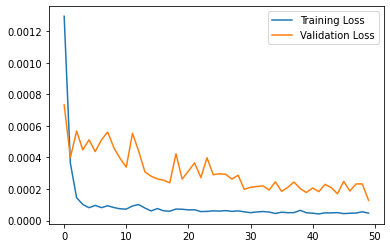

In [ ]:
if(train_new_model):
  plt.plot(hist.history['loss'],label='Training Loss')
  plt.plot(hist.history['val_loss'],label='Validation Loss')
  plt.legend()

  plt.show()

#### Testing

In [7]:
y_pred_train = model.predict(x)
y_pred_test = model.predict(x_test)

313/313 [==============================] - 19s 59ms/step


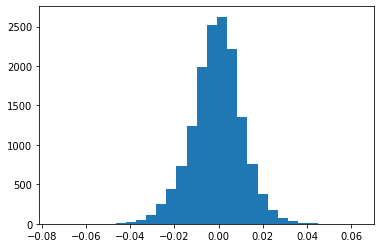

In [7]:
#train data
plt.hist(y_pred_train, bins=30)
plt.show()

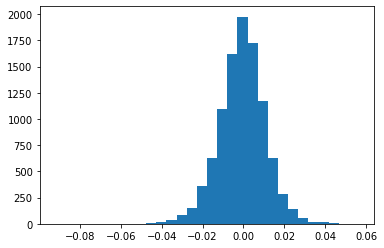

In [8]:
#test data
plt.hist(y_pred_test, bins=30)
plt.show()

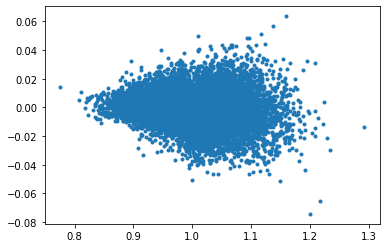

In [9]:
#train data
plt.plot(S[:,-1], y_pred_train, marker = ".", linestyle='none')
plt.show()

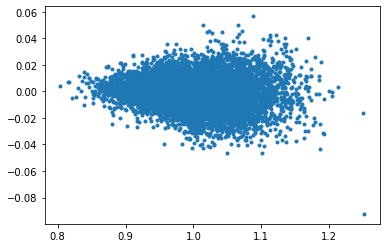

In [10]:
#test data
plt.plot(S_test[:,-1], y_pred_test, marker = ".", linestyle='none')
plt.show()

In [8]:
# Train data
print(np.mean(y_pred_train))
print(np.std(y_pred_train))

# Test data
print(np.mean(y_pred_test))
print(np.std(y_pred_test))

-0.0008306207
0.01136254
-0.0006850404
0.011288831


In [9]:
#monte carlo pricing
call_payoffs = [max(0, s[-1] - K) for s in S]
call_mc_price = np.mean(call_payoffs) * np.exp(-r*T)
call_mc_price

0.023570885194667733

In [ ]:
# Save the model to Google Drive
# model.save('/content/drive/My Drive/final_project_financial_eng/200dt_mlp_vanilla_opt_model.h5')